<a href="https://colab.research.google.com/github/BenBritons/DS_notebooks/blob/main/NLP/PredictionJobSalary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large scale text analysis with deep learning

Today I'm gonna apply the newly learned tools for the task of predicting job salary.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
let's download and unpack the data from [here].

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c job-salary-prediction

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip job-salary-prediction.zip

In [ ]:
data = pd.read_csv("/kaggle/input/job-salary-prediction/Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

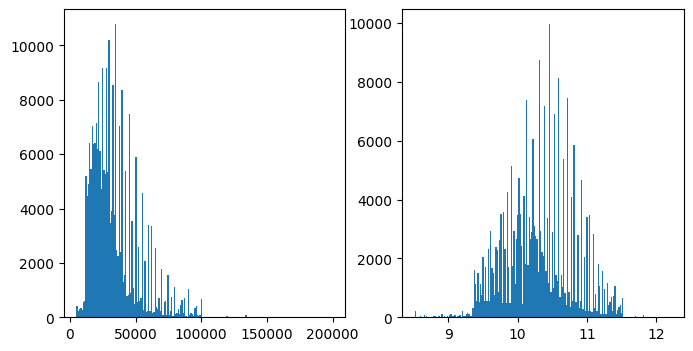

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=200);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=200);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
126759,70006767,Nurse : Staff Nurse Guernsey AWS/GUER****,Medical Staff Nurse Guernsey **** **** Enjoy...,"Cornwall, Devon",UK,NaN,permanent,NaN,Healthcare & Nursing Jobs,26000 - 28000. Frequency: Annually,27000,jobs4medical.co.uk,10.203629
129147,70141661,"Systems / IT Manager, MS Dynamics NAV, London,...","Systems / IT Manager, MS Dynamics NAV, London,...",London Greater London,London,NaN,permanent,NaN,IT Jobs,50000,50000,technojobs.co.uk,10.819798
35248,68234531,Demi Chef de Parti ****Hotel AA rosette amaz...,Demi chef de Partie amazing opportunity star...,London South East,South East London,NaN,NaN,The Change Group,Hospitality & Catering Jobs,16000 - 18000 per annum,17000,caterer.com,9.741028


### Preprocessing text data

Applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

I'm gonna to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"].apply(lambda x : ' '.join(tokenizer.tokenize(x.lower())))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0         engineering systems analyst dorking surrey sal...
1         stress engineer glasgow salary **** to **** we...
2         mathematical modeller / simulation analyst / o...
3         engineering systems analyst / mathematical mod...
4         pioneer , miser engineering systems analyst do...
                                ...                        
244763    position : qualified teacher subject / special...
244764    position : qualified teacher or nqt subject / ...
244765    position : qualified teacher subject / special...
244766    position : qualified teacher subject / special...
244767    this entrepreneurial and growing private equit...
Name: FullDescription, Length: 244768, dtype: object

In [ ]:
data["FullDescription"] = data["FullDescription"].apply(lambda x : ' '.join(tokenizer.tokenize(x.lower())))
data["Title"] = data["Title"].apply(lambda x : ' '.join(tokenizer.tokenize(str(x).lower())))

In [ ]:
data["Title"].sample(10)

96764              building services mechanical engineer
65710                                       chef manager
1085                 open day for care assistant in kent
40080                         it service management lead
138342    family court advisor hampshire immediate start
100645                       general builder / carpenter
50459             store manager store opening in october
198208                technical internal sales executive
211933                      reward & recognition manager
192461                              net developer exeter
Name: Title, dtype: object

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
data["FullDescription"].values

array(['engineering systems analyst dorking surrey salary **** k our client is located in dorking , surrey and are looking for engineering systems analyst our client provides specialist software development keywords mathematical modelling , risk analysis , system modelling , optimisation , miser , pioneeer engineering systems analyst dorking surrey salary **** k',
       'stress engineer glasgow salary **** to **** we re currently looking for talented engineers to join our growing glasgow team at a variety of levels . the roles are ideally suited to high calibre engineering graduates with any level of appropriate experience , so that we can give you the opportunity to use your technical skills to provide high quality input to our aerospace projects , spanning both aerostructures and aeroengines . in return , you can expect good career opportunities and the chance for advancement and personal and professional development , support while you gain chartership and some opportunities to pos

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for x in data["FullDescription"].values + data["Title"].values:
  token_counts.update(x.split())


In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
print('Correct!')

Total unique tokens : 253743
('and', 2657309)
('.', 2453599)
(',', 2317992)
('the', 2080902)
('to', 2018611)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


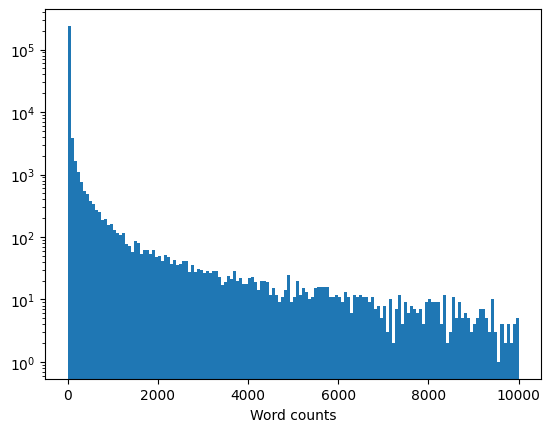

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=150, log=True)
plt.xlabel("Word counts");

Get a list of all tokens that occur at least 11 times.

In [ ]:
min_count = 11

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
tokens[::20]

['UNK',
 "')",
 '(****)',
 '(‘',
 ').senior',
 ')c',
 ')front',
 ')mortgage',
 ')registered',
 ')trainee',
 '****(****)****',
 '****/',
 '****:****:',
 '****ad',
 '****apprentice',
 '****b',
 '****building',
 '****cdp',
 '****clerical',
 '****conference',
 '****creative',
 '****desktop',
 '****duty',
 '****endoscopy',
 '****executive',
 '****fleet',
 '****fundraising',
 '****hgv',
 '****inbound',
 '****ios',
 '****leading',
 '****machine',
 '****mental',
 '****nhs',
 '****optical',
 '****payroll',
 '****power',
 '****professional',
 '****real',
 '****resourcing',
 '****scientific',
 '****sipp',
 '****staff',
 '****systems',
 '****tester',
 '****unit',
 '****welder',
 '++),',
 ',head',
 '.1st',
 '.adult',
 '.art',
 '.band',
 '.c',
 '.ce',
 '.cleaner',
 '.compiler',
 '.corporate',
 '.demand',
 '.door',
 '.emea',
 '.excellent',
 '.fire',
 '.functional',
 '.hgv',
 '.immigration',
 '.inventory',
 '.leading',
 '.m',
 '.mechanical',
 '.multiskilled',
 '.obiee',
 '.paediatric',
 '.perm',
 '.pp

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34778
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = {}
for i, x in enumerate(tokens):
  token_to_id[x] = i

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary I've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[12126 30668  3623     1     1]
 [16152  4292     1     1     1]
 [28276 11522    14 16339 12121]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [ ]:
data[categorical_columns].apply(dict, axis=1)

0         {'Category': 'Engineering Jobs', 'Company': 'G...
1         {'Category': 'Engineering Jobs', 'Company': 'G...
2         {'Category': 'Engineering Jobs', 'Company': 'G...
3         {'Category': 'Engineering Jobs', 'Company': 'G...
4         {'Category': 'Engineering Jobs', 'Company': 'G...
                                ...                        
244763    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244764    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244765    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244766    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244767    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
Length: 244768, dtype: object

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
data.sample(8)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
163164,71213985,recruitment / office administrator nottingham,recruitment / office administrator nottingham ...,Nottingham,Nottingham,full_time,NaN,Other,Admin Jobs,16000,16000,careerbuilder.com,9.680407
180750,71591758,web front end & cms developer,central brighton based business are looking fo...,Brighton,Brighton,full_time,NaN,Other,IT Jobs,"30,000.00 - 35,000.00 per year",32500,Jobcentre Plus,10.389026
100326,69539855,resourcer,"our client , a leading professional recruitmen...","Reading, Berkshire",Reading,NaN,permanent,Focus Resourcing,HR & Recruitment Jobs,18000 - 23000/annum OTE,20500,cv-library.co.uk,9.928229
244557,72697269,business support assistant,job purpose : the jobholder will be responsibl...,Hertfordshire,Hertfordshire,NaN,permanent,Other,Engineering Jobs,Upto UKP 25680 per year,25680,justengineers.net,10.153506
63451,68704053,engineers setting out,a privately owned civil engineering contractor...,Guildford Surrey South East,Guildford,NaN,permanent,Candidate Source Ltd,Graduate Jobs,20000 - 30000 dependent on experience,25000,totaljobs.com,10.126671
112348,69690165,interim hr manager,huxley associates are currently working with a...,London London England,London,NaN,NaN,Huxley Associates,HR & Recruitment Jobs,45000 -45000 per annum,45000,gojobsearch.co.uk,10.714440
199706,71851592,project manager,scope manage projects to agreed time and cost ...,Witney Oxfordshire South East,Witney,NaN,permanent,Other,Other/General Jobs,"From 40,000 to 50,000 per annum",45000,totaljobs.com,10.714440
114185,69748293,"rgn sexual health , family planning , register...","position rgn sexual health , family planning ,...",Essex,Essex,NaN,permanent,Support Services Group,Healthcare & Nursing Jobs,30000 - 33000/annum,31500,cv-library.co.uk,10.357775


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
MAX_LEN_DES = 1200
MAX_LEN_TITLE = 150

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, MAX_LEN_TITLE)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, MAX_LEN_DES)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
example = make_batch(data_train[:3])

In [ ]:
example['FullDescription'].get_device()

0

In [ ]:
model.cuda()
print(model(example))

tensor([[-0.0922],
        [-0.1205],
        [-0.0574]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:

batch = make_batch(data_train[:100])

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64,
                 tit_len = MAX_LEN_TITLE, des_len = MAX_LEN_DES, emb_size = 150):
        super().__init__()
        self.tit_emb = nn.Embedding(n_tokens, emb_size)
        self.tit_conv = nn.Conv1d(emb_size, 16, kernel_size=3)
        self.tit_relu = nn.ReLU()
        #self.tit_pool = nn.MaxPool1d(tit_len - 2)
        self.des_emb = nn.Embedding(n_tokens, emb_size)
        self.des_conv = nn.Conv1d(emb_size, 32, kernel_size=3)
        self.des_relu = nn.ReLU()
        #self.des_pool = nn.MaxPool1d(des_len - 2)
        self.norm2 = nn.LayerNorm(n_cat_features)
        self.cat_fc = nn.Linear(n_cat_features, n_cat_features)
        self.cat_relu = nn.ReLU()
        self.fc = nn.Linear(16+32 + n_cat_features, hid_size)
        self.relu = nn.ReLU()
        self.final = nn.Linear(hid_size, 1)
        self.norm = nn.LayerNorm(16+32 + n_cat_features)

    def forward(self, batch):
#       print(batch['Title'].size())
#       print(batch['FullDescription'].size())
      m1 = nn.MaxPool1d(batch['Title'].size()[1] - 2)
      title_procesed = m1(self.tit_relu(self.tit_conv(self.tit_emb(batch['Title']).permute(0,2,1))))
      m2 = nn.MaxPool1d(batch['FullDescription'].size()[1] - 2)
      description_procesed = m2(self.des_relu(self.des_conv(self.des_emb(batch['FullDescription']).permute(0,2,1))))
      categorial_procesed = self.cat_relu(self.cat_fc(self.norm2(batch['Categorical'])))
      title_procesed = title_procesed.reshape(batch['Title'].size()[0], 16)
      description_procesed = description_procesed.reshape(batch['FullDescription'].size()[0], 32)
#       print(title_procesed.size())
#       print(description_procesed.size())
#       print(categorial_procesed.size())
      fin = torch.cat((title_procesed, description_procesed,
                                                      categorial_procesed), 1)
#       print(fin.size())
      finals = self.final(self.relu(self.fc(self.norm(fin))))
#       print(finals.size())
      return finals



In [ ]:
model = SalaryPredictor()

In [ ]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

print(type(batch['Title']))

In [ ]:
batch['Title'].size()

torch.Size([100, 17])

In [ ]:
emb = nn.Embedding(len(tokens), 50)
emb.cuda()
bb = emb(batch['Title'].to(device))

In [ ]:
bb.size()

torch.Size([100, 8, 15])

In [ ]:
des_conv = nn.Conv1d(15, 8, kernel_size=3)
des_conv.cuda(device)
bb = des_conv(bb.to(device).permute(0,2,1))

In [ ]:
bb.size()

torch.Size([100, 8, 15])

In [ ]:
relu = nn.ReLU()
bb = relu(bb)


In [ ]:
bb.size()

torch.Size([100, 8, 15])

In [ ]:
mp = nn.MaxPool1d(15)
mp(bb).size()

torch.Size([100, 8, 1])

In [ ]:
model.cuda()
dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

In [ ]:
dummy_pred = torch.reshape(dummy_pred, (100,))

In [ ]:

assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        #print(batch['Title'].size())
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 5.07985
Mean absolute error: 7.32456
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 4.02466
Mean absolute error: 6.44312
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 3.87223
Mean absolute error: 6.32883
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 3.96518
Mean absolute error: 6.39775
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 3.86062
Mean absolute error: 6.33184


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 29881
Salary (gbp): tensor([[31151.0352]])


key account manager abrasives

key account manager uk ireland ******** bonus , car benefits there could never be a better time to join this major , global manufacturer . they are one of the major players in the field of diamond cutting tools and abrasives and cover a range of industries including construction , engineering , manufacturing , industrial and automotive . they are renowned for the quality of their product and service . continued success has resulted in a newly created role for a talented key account manager . working from home and reporting to the national sales manager , you will be responsible for managing existing and securing new key account business . you will be defining and implementing strategies for generating key account sales , and preparing target plans to identify and achieve short , medium and long term objectives . your brief will include the identification of new sales opportunities via new account generation whilst building strong relationships at all levels . you ' ll be liaising with the national sales manager on a regular basis in order to develop sales within the key account headquarters and the branches via support from the trade sales team . centrally based , it is essential that you can demonstrate success in winning , developing and managing key account business as well as showing extensive experience selling via distributors and resellers . your experience will have been gained in the abrasives , cutting tools , power tools , hand tools or industrial supplies market . first class communication and presentation skills are essential together with it literacy , attention to detail , and the discipline , initiative and motivation required to work successfully from home . this is a superb opportunity to progress your career with a forward thinking , innovative organisation . this job was originally posted as www . totaljobs . com / jobseeking / UNK ****

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)